## <span style="color:#000080"> **Modelo Desenvolvido**
### <span style="color:#4169E1"><b>Predição serie-temporal de valores de Magnitude do Vento Verificado(m/s) utilizando Redes Neurais Long Short-Term Memory (LSTM) do Keras. <br>
    
<b>Objetivos pricipais deste tutorial:</b><br>
- Preparar os dados para que eles se adequem ao formato de um problema de predição serie-temporal
- Desenvolver um modelo LSTM para predição de series-temporais
- Avaliar o desempenho da rede LSTM para predição de valores para multiplos pontos no tempo.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from math import sqrt

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_regression

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.inspection import plot_partial_dependence

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


### ***A) Importar Dados de Chuvas, Pressao, Precipitação e Temperatura***

In [2]:
source_file = '../../Data/process/resultDados_patio1_completo.csv'
dataframe = pd.read_csv(source_file, delimiter=';',  index_col=0, parse_dates=['Data'])

In [3]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8760 entries, 0 to 8759
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Longitude            8760 non-null   float64       
 1   Latitude             8760 non-null   float64       
 2   Magnitude_Observada  8760 non-null   float64       
 3   Direcao              8760 non-null   float64       
 4   Data                 8760 non-null   datetime64[ns]
 5   Valor_Pressao        8760 non-null   float64       
 6   Valor_Temp           8760 non-null   float64       
 7   Valor_Chuva          8760 non-null   float64       
 8   Magnitude_Verif      8760 non-null   float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 684.4 KB


### <span style="color:#006400"> **B) Algoritmo do Modelo de Rede Neural**

Iremos transformar os dados de séries temporais para um problema de aprendizado supervisionado, isto é, 
transformar de uma lista de números para uma lista de padrões de entrada e saída.
Podemos conseguir isso usando uma função pré-preparada chamada <b>series_to_supervised().</b>

In [71]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from math import sqrt
from datetime import datetime

#### <span style="color:#006400"> B.1)**Transformando de series temporais para um problema de aprendizado supervisonado**

Como podemos observar no método abaixo, o objetivo dela é criar uma sequencia de informações.<br>
É utilizada a função <b>shift</b> do pandas para que seja concatenada uma coluna com n posições de deslocamento.<br>
Dessa maneira poderemos colocar o mês de entrada (X), e os N meses de saída à frente (y)

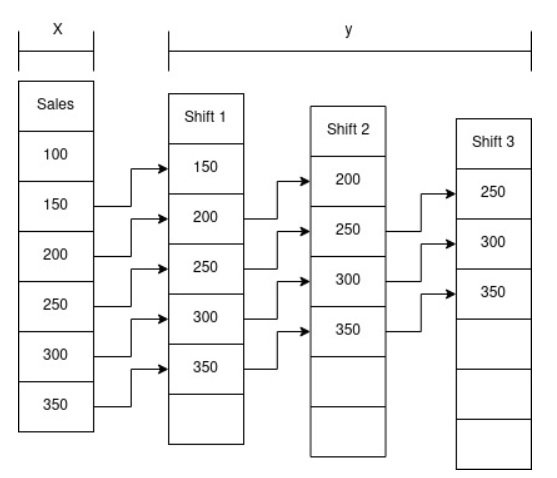

In [85]:
from IPython.display import Image
Image(filename='shift.jpg')

In [72]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    import pandas as pd
    
    # ###################################################### 
    # Frame a time series as a supervised learning dataset.
    # Arguments:
    #    data: Sequence of observations as a list or NumPy array.
    #    n_in: Number of lag observations as input (X).
    #    n_out: Number of observations as output (y).
    #    dropnan: Boolean whether or not to drop rows with NaN values.
    # Returns:
    #    Pandas DataFrame of series framed for supervised learning.
    # ###################################################### 

    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()

    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))   # Copia os valores pra frente
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [99]:
n_lag = 1  # Features
n_sec = 7  # Saidas (dias a frente)

df_serietemporal = dataframe.drop(['Longitude', 'Latitude','Magnitude_Observada','Direcao','Valor_Pressao','Valor_Temp','Valor_Chuva'], axis=1)
df_serietemporal = df_serietemporal.set_index('Data')

raw_values = df_serietemporal.values
raw_values = raw_values.reshape(len(raw_values),1)
print(raw_values.shape)
raw_values

(8760, 1)


array([[9.82],
       [8.74],
       [8.45],
       ...,
       [6.04],
       [6.72],
       [5.61]])

In [100]:
supervised = series_to_supervised(raw_values, n_lag, n_sec)   # Dataframe com Valores, Feautres de Entrada, Output de Saida
supervised

,var1(t-1),var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6)
1,9.82,8.74,8.45,9.18,9.19,9.36,8.40,7.40
2,8.74,8.45,9.18,9.19,9.36,8.40,7.40,7.83
3,8.45,9.18,9.19,9.36,8.40,7.40,7.83,7.38
4,9.18,9.19,9.36,8.40,7.40,7.83,7.38,7.10
5,9.19,9.36,8.40,7.40,7.83,7.38,7.10,6.60
...,...,...,...,...,...,...,...,...
8749,4.46,5.40,5.27,6.98,6.75,6.00,6.84,7.22
8750,5.40,5.27,6.98,6.75,6.00,6.84,7.22,6.14
8751,5.27,6.98,6.75,6.00,6.84,7.22,6.14,6.04
8752,6.98,6.75,6.00,6.84,7.22,6.14,6.04,6.72


#### <span style="color:#006400"> B.2)**Dividindo dataset em treino e teste**

In [101]:
# Sabemos que as ultimas 744 linhas do dataset contêm informações sobre os dados do Conjunto de Teste

size = supervised.shape[0] - 1000
n_test = 1000

supervised_values = supervised.values

# separando em conjunto de treino e conjunto de teste
train, test = supervised_values[0:size], supervised_values[-n_test:]

print(test)
print(train.shape)
print(test.shape)

[[4.23 4.67 5.15 ... 5.34 5.12 4.44]
 [4.67 5.15 4.69 ... 5.12 4.44 4.21]
 [5.15 4.69 4.82 ... 4.44 4.21 4.43]
 ...
 [5.27 6.98 6.75 ... 7.22 6.14 6.04]
 [6.98 6.75 6.   ... 6.14 6.04 6.72]
 [6.75 6.   6.84 ... 6.04 6.72 5.61]]
(7753, 8)
(1000, 8)


#### <span style="color:#006400"> B.2)**Rede LSTM**

Antes de usarmos o LSTM precisamos fazer duas mudanças nos dados:<br>
- Estacionário. Os dados mostram uma tendência crescente que deve ser removida por diferenciação. Utilizaremos uma função chamada difference() que transformará os valores da serie temporal em uma serie de diferenças
- Escala. A escala dos dados deve ser reduzida para valores entre -1 e 1 compatível com a função de ativação das unidades LSTM. Utilizaremos o MinMaxScaler do sklearn.

In [102]:
# create a differenced series
# ---------------------------------------
def difference(dataset, interval=1):
    import pandas as pd
    diff = list()

    for i in range(interval,len(dataset)):
        values = dataset[i] - dataset[i - interval]
        diff.append(values)
        
    return pd.Series(diff)

In [103]:
# Tranformando series temporais em um problema para LSTM
# ---------------------------------------
def prepare_data(series, n_test, n_lag, n_seq):

    # Extrair dados brutos
    raw_values = series.values
    raw_values = raw_values.reshape(len(raw_values),1)
    
    #Transformar para ser estacionario
    diff_series = difference(raw_values,1)
    diff_values = diff_series.values
    diff_values = diff_values.reshape(len(diff_values),1)
    
    #Reescalar os valores para ficar entre -1 e 1
    scaler = MinMaxScaler(feature_range=(-1 , 1))
    scaled_values = scaler.fit_transform(diff_values)
    scaled_values = scaled_values.reshape(len(scaled_values),1)

    #Transformaremum problema de aprendizado supervisionado
    supervised = series_to_supervised(scaled_values, n_lag, n_seq)
    supervised_values = supervised.values

    # Dividindo os conjuntos de treino e teste
    train, test = supervised_values[0:size], supervised_values[-n_test:]
    
    return scaler, train, test


In [105]:
scaler, train, test = prepare_data( df_serietemporal, n_test, n_lag, n_sec)
# print(test)
# print(train.shape)
# print(test.shape)

#### <span style="color:#006400"> B.3)**Treinando o modelo em LTSM**

Isso requer primeiro que o conjunto de dados de treinamento seja transformado de uma matriz 2D[samples, features] para uma matriz 3D[samples, timesteps, features]. Fixaremos as etapas de tempo em 1, portanto, essa alteração é direta.<br:

<b>Rede LSTM:</b>
- Hidden Layer LSTM 
- Output Layer com 7 valores de saída
- Função de perda utilizado é o erro quadratico médio (MSE)
- Otimizador ADAM.

A rede LSTM é guarda o estado, portanto teremos que resetar o estado da rede a cada época, pois queremos expor para a rede toda a sequência, e fazê-la aprender interdependências e não um conjunto restrito de regras.<p>
O mesmo batch size deve ser usado para treinamento e teste, e como exigimos que sejam feitas previsões em cada etapa do conjunto de dados de teste, significa o batch size deve ser 1. Um batch size igual a 1 também é chamado de aprendizado on-line, pois os pesos da rede serão atualizados durante o treinamento após cada padrão de treinamento.

In [106]:
# Transformando em um matriz 3D
X_train, Y_train = train[:, 0:n_lag], train[:,n_lag:]
X_train = X_train.reshape(X_train.shape[0], 1 , X_train.shape[1])
X_test, Y_test = test[:, 0:n_lag], train[:,n_lag:]

# Montando a Rede
model = Sequential()
model.add(LSTM(1, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]),stateful=True))
model.add(Dense(Y_train.shape[1]))
model.compile(loss='mean_squared_error', optimizer='adam')

#Realizando treinamento
for i in range(1500):
    model.fit(X_train, Y_train, epochs=1, batch_size=1, verbose=0, shuffle=False)
    model.reset_states()

#### <span style="color:#006400"> B.4)**Realização das Predições**

In [107]:
# Realizando um predição

def forecast_lstm(model, X):
    # Transformando X para o formato 3D [samples, timesteps, features]
    X = X.reshape(1,1,len(X))
    
    # Realizando predicao
    forecast = model.predict(X, batch_size=1)

    #Convertendo para array
    return [x for x in forecast[0,:]]



#### <span style="color:#006400"> B.5)**Avaliação do Modelo**

Um cenário de previsão contínua será utilizado, também chamado de validação walk-forward
<p>
Cada etapa do conjunto de dados de teste será percorrida uma de cada vez. Um modelo será usado para fazer uma previsão para o intervalo de tempo; em seguida, o valor real do próximo mês do conjunto de dados de testes será disponibilizado ao modelo para realizar a predição no próximo intervalo de tempo. Imitando um cenário de mundo real, onde os valores reais vão sendo disponibilidos para serem utilizados nas pŕoximas predições.
<p>
Será utilizado o <b>Root Mean Squared Error (RMSE)</b> para avaliação do modelo



In [108]:

# Avaliando o modelo para cada passo do dataset de teste
Y_pred = list()
for i in range(len(test)):
    X_test, Y_test = test[i, 0:n_lag], test[i,n_lag:]

    # Realizando predicao
    forecast = forecast_lstm(model, X_test)

    # Salvando o resultado
    Y_pred.append(forecast)                  

#### <span style="color:#006400"> B.5)**Invertendo transformações para análise dos resultados**

In [109]:
# invert differenced forecast

def inverse_difference(last_ob, forecast):
    
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)

    # propagate difference forecast using inverted first values
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted

In [110]:
# Transformando os valores preditos para a escala real

def inverse_transform(series, forecasts, scaler, n_test):
    inverted = list()
    for i in range(len(forecasts)):
        
        #Criando um array das predições
        forecast = np.array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))

        #Invertendo escala
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
    
        # Invertendo diferença
        index = len(series) - n_test + i -1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)

        # Guardando valores
        inverted.append(inv_diff)
    return inverted

#### <span style="color:#006400"> B.6)**A Raiz Quadrada do Valor Médio Quadrático**

In [111]:
# invertendo as tranormações daspredições
Y_pred = inverse_transform(df_serietemporal, Y_pred, scaler,n_test + 2)

# Avaliando os resultados
for i in range(n_sec):
    actual = [row[i] for row in test]
    predicted = [forecast[i] for forecast in Y_pred]    
    rmse = sqrt(mean_squared_error(actual, predicted))
    print('t+%d RMSE: %f' % ((i+1), rmse)) # Erro da Raiz da Média Quadrada
    
    

t+1 RMSE: 7.186198
t+2 RMSE: 7.122909
t+3 RMSE: 7.069743
t+4 RMSE: 7.012767
t+5 RMSE: 6.961066
t+6 RMSE: 6.927327
t+7 RMSE: 6.885188
